# Gaussian process regression using functional programming
## With an example comparison between optimization and marginalization in Bayesian inference
### by Luca Ambrogioni

Gaussian process (GP) regression is a powerful Bayesian technique that uses infinite-dimensional prior distributions over a space of functions. The general regression problem can be written as follows

$$ y_t = f(t) + \epsilon_t,$$

where $y_t$ is the datapoint measured at time $t$, $f(t)$ is the underlying function that we want to estimate and $\epsilon_t$ is measurement noise. 

In statistics, the most common approach to this problem is to define a parametric form for $f(x)$ and optimize its paramters. For example, a linear regression is obtained by using the linear form $f(t) = a t + b$ where both the slope $a$ and the intercept $c$ need to be estimated. This can be done, for example, by assigning a Gaussian prior distribution over the parameters $a$ and $b$. The result is the standard Bayesian linear regression.

The parametric approach imposes strong constaints on the underlying space of functions. An elegant and flexible alternative is to assign a prior distribution directly on the (infinite-dimensional) space of functions $f(t)$. While this idea can sound very complicated, everything becomes very simple and intuitive if we use GP priors, which generalizes multivariate Gaussian distribution to infinite-dimensional spaces. We say that the function $f(t)$ follows a prior GP distribution with mean function $m(t)$ and covariance function $k(t_1,t_2)$. In formulas:

$$ f(t) \sim \mathcal{G}\mathcal{P}\big( m(t), k(t_1, t_2) \big).$$

The mean function determines the mean of $f(t)$ at each time point, while the covariance function determines the covariance between the values of $f(t)$ at each pair of time points. It is easy to see that they are the analogous of mean vector and covariance matrix respectively. 

In this Jupiter notebook, I will show how to use the functional GP toolbox and I will give a simple example that shows the benefid of marginalizing over a famility of covariance functions instead of using optimization techniques. The main feature of the toolbox is that it outputs $\lambda$ functions instead of numerical arrays. This is possible because the posterior distribution of a GP regression is fully characterized by its mean and covariance functions, which are weighted combinations of the prior covariance functions centered at the location of the datapoints:

$$ PosteriorMean(t) = \sum_j w_j k(t, t_j)$$

&

$$ PosteriorCovariance(t_1, t_2) = \sum_{m,n} h_{mn} k(t_1, t_m) k(t_2, t_n)$$

where the weights $w_j$ and $h_{mn}$ can be obtained in closed-form (see Rasmussen, 2006). Most implemetations of GP regression output the values of the posterior mean and covariance at a series of pre-determined target points. This hides the functional nature of the posterior distribution.

Let's start by importing the toolbox (plus Matplotlib and Numpy)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from functional_gp_toolbox import kernel_tools 
from functional_gp_toolbox import GP_regression_tools

In this example, I will work with random periodic functions. Therefore, I will use the periodic covariance function. The **kernel_tools** object can be used for constructing the covariance function and for sampling random functions and datapoints. 

Prior to the generation of the data, I also randomly sample the frequency of the covariance function. Therefore, the next block generates a random periodic signal with a random frequency.

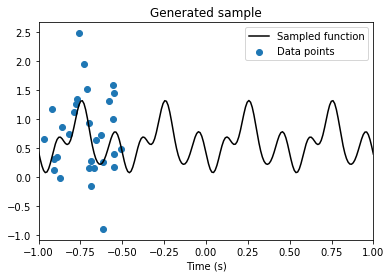

In [58]:
k_tools = kernel_tools()
#kernel = k_tools.get_polynomial_kernel(order = rnd.choice(range(0,9)))
#kernel = k_tools.get_squared_exponential_kernel(length_scale = np.random.uniform(low = 0.05, high = 0.5))
kernel = k_tools.get_periodic_kernel(frequency = np.random.uniform(low = 0.2, 
                                                                   high = 5))

number_functions = 1
function_length = 200
function_range = np.linspace(-1,1,function_length)

number_samples = 30
sample_indices = np.sort(np.random.choice(range(0,function_length/4), 
                                          size = (number_samples,), 
                                          replace = "no")).tolist()
sample_range = function_range[sample_indices]

noise_level = 0.5
functions = k_tools.get_function_from_kernel(kernel, 
                                             number_functions, 
                                             function_range)
corrupted_samples = k_tools.get_corrupted_samples(functions, 
                                                  sample_indices,
                                                  noise_level = noise_level)
k_tools.plot_corrupted_samples(function_range, 
                               functions, 
                               sample_range, 
                               corrupted_samples)
plt.xlabel("Time (s)")

I can now analyze the data using the **GP_regression_tools ** object. In other words, I will input the datapoints (blue dots) to the toolbox and I will obtain a probabilistic estimate of the underlying function (black line). This output will be a $\lambda$ function that we can subsequently evaluate at any arbitrary time point.

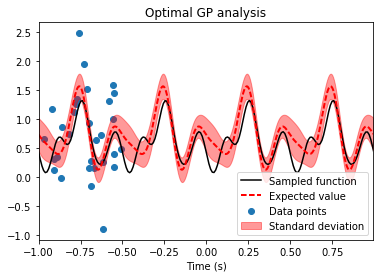

In [59]:
## Optimal GP analyss ##
GP_tools = GP_regression_tools()
GP_posterior = GP_tools.get_GP_regression_posterior(data_points = corrupted_samples[0], 
                                                    kernel = kernel, 
                                                    data_range = sample_range, 
                                                    noise_level = noise_level)
target_range = np.arange(-1.,1.,0.005)
k_tools.plot_corrupted_samples(function_range, 
                               functions, 
                               sample_range, 
                               corrupted_samples)
GP_tools.plot_GP_posterior(GP_posterior_expectation = GP_posterior["expectation"], 
                           GP_posterior_variance = GP_posterior["variance"],
                           target_range = target_range)
plt.title("Optimal GP analysis")
plt.xlabel("Time (s)")

Besides the posterior mean and covariance functions, as plotted in the previous cell, the toolbox also output the (Gaussian)  marginal posterior probability density functions, again expressed as a $\lambda$ function:

$$PosteriorDensity(x,t) = \frac{\exp{-\frac{(x - PosteriorMean(t))^2}{2 PosteriorCovariance(t,t)}}}{\sqrt{2 \pi PosteriorCovariance(t,t)}} $$

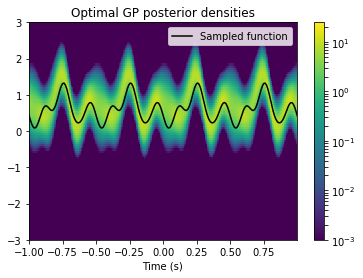

In [60]:
## Optimal GP analysys (PDF) ##
value_range = np.linspace(-3.,3.,100)
k_tools.plot_corrupted_samples(function_range, 
                               functions, 
                               sample_range, 
                               corrupted_samples,
                               plot_samples = "no")
GP_tools.plot_posterior_pdf(GP_posterior["pdf"], value_range, target_range)
plt.title("Optimal GP posterior densities")
plt.xlabel("Time (s)")

In the previous analysis I assumed to know the frequency of the underlying function. In real-wold applications we would often need to infer the frequency (or other parameters of the GP prior) from the datapoints themselves. Fortunately, the GP formalism allows to easily compute the likelihood: 

$$p(data|frequency).$$

In the next block, I run the GP analysis for a series of periodic covariance functions with different frequencies.

In [61]:
# multiple GP analysis
freq_list = np.arange(0.2,5.,0.1)
kernels_list = [k_tools.get_periodic_kernel(frequency = l) for l in freq_list]
results_list = GP_tools.multiple_GP_analysis(data_points = corrupted_samples[0], 
                                             kernels_list = kernels_list, 
                                             data_range = sample_range, 
                                             noise_level = noise_level)


Using the Bayes theorem with a uniform prior distribution over the frequency, I can obtain the probability of the frequency given the data:

$$p(frequency|data)$$ 

I plot this probability in the next cell.

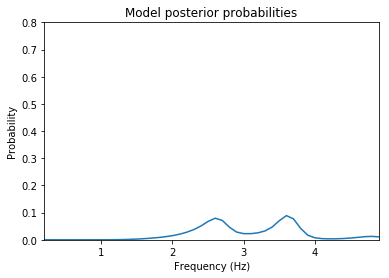

In [62]:
# Model posterior probabilities

meta_results = GP_tools.meta_GP_analysis(results_list)
plt.plot(np.array(freq_list), meta_results["probabilities"])
plt.ylim(0.,0.8)
plt.xlim(min(freq_list),max(freq_list))
plt.title("Model posterior probabilities")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Probability")

Most users of GP analysis would now select the frequency value with the highest probability. However, this approach completely neglects the uncertainty in the posterior distribution. In the next two cells, I plot the resul of this optimized GP analysis.

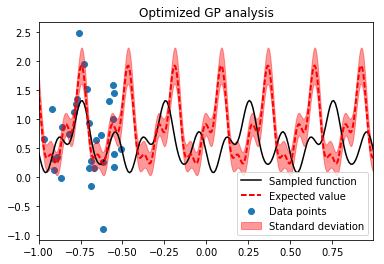

In [63]:
## Optimized posterior analysis ##
k_tools.plot_corrupted_samples(function_range, 
                               functions, 
                               sample_range, 
                               corrupted_samples)
GP_tools.plot_GP_posterior(GP_posterior_expectation = meta_results["optimized"]["expectation"], 
                           GP_posterior_variance = meta_results["optimized"]["variance"],
                           target_range = target_range)
plt.title("Optimized GP analysis")

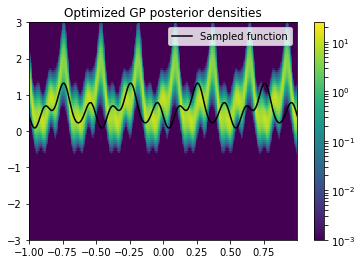

In [64]:
k_tools.plot_corrupted_samples(function_range, 
                               functions, 
                               sample_range, 
                               corrupted_samples,
                               plot_samples = "no")
GP_tools.plot_posterior_pdf(meta_results["optimized"]["pdf"], 
                            value_range, 
                            target_range)
plt.title("Optimized GP posterior densities")

It is clear that small errors in the frequency estimation can lead to catastrophically bad predictions. In fact, I am assuming to be certain about the frequency of the underlying function but, unless I am very lucky, the frequency that optimizes my posterior is close but not exaclty equal to the real frequency. When I extrapolate to the future, this small error accumulates and leads to very bad predictions.

The Bayesian solution to this problem is to marginalize out the frequency variable. In other words, I can sum the predictions associated with each frequency weighted by the probability of the frequency. 

The toolbox implemets this marginalization, the result is again a $\lambda$ function.

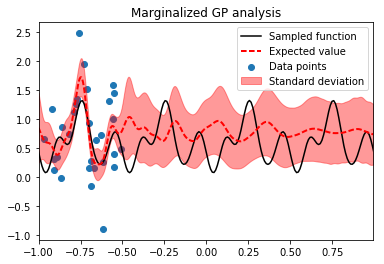

In [65]:
## Marginalized GP analysis ##
k_tools.plot_corrupted_samples(function_range, 
                               functions, 
                               sample_range, 
                               corrupted_samples)
GP_tools.plot_GP_posterior(GP_posterior_expectation = meta_results["marginalized"]["expectation"], 
                           GP_posterior_variance = meta_results["marginalized"]["variance"],
                           target_range = target_range)
plt.title("Marginalized GP analysis")

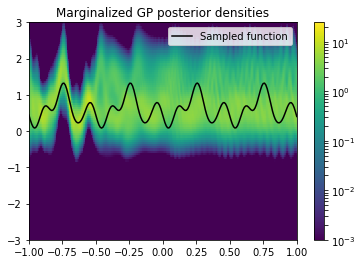

In [66]:
GP_tools.plot_posterior_pdf(meta_results["marginalized"]["pdf"], 
                            value_range, 
                            target_range)
k_tools.plot_corrupted_samples(function_range, 
                               functions, 
                               sample_range, 
                               corrupted_samples,
                               plot_samples = "no")
plt.title("Marginalized GP posterior densities")

The marginalization leads to a more reliable probability distribution at the price of extra computation.